# Обучение с Diffusers models

В последние годы стало ясно, что диффузионные модели заняли трон самых современных генеративных моделей. Здесь используется новая библиотека [Diffusers] (https://github.com/huggingface/diffusers) Hugging Face для обучения простой диффузионной модели.

# Предварительная подготовка

In [ ]:
!pip install datasets
!pip install diffusers[training]==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import torch.nn.functional as F
from dataclasses import dataclass
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers import DDPMPipeline
import math
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from accelerate import notebook_launcher
from tqdm.auto import tqdm
from pathlib import Path
import os
import glob
from diffusers import DDPMScheduler
from PIL import Image
from diffusers.optimization import get_cosine_schedule_with_warmup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Поделиться моделью с сообществом Hugging Face

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Нужно установить Git-LFS, чтобы загружать контрольные точки модели:


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
!git lfs install
# !git clone https://huggingface.co/DanGlado/Duff_Hyundai_test

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


# Конфигурация

Для удобства определим конфигурацию, объединяющую все обучающие гиперпараметры.
Здесь мы выбираем разумные значения по умолчанию для гиперпараметров, таких как «num_epochs», «learning_rate», «lr_warmup_steps».
Например, num_epochs можно увеличить до 100 для лучшего визуального качества.

Параметры по умолчанию

    image_size = 128  # Разрешение сгенерированных изображений
    train_batch_size = 16 # Кол-во примеров изображений для обучения одновременно
    eval_batch_size = 16  # Кол-во примеров изображений для оценки одновременно
    num_epochs = 50 # Кол-во эпох
    gradient_accumulation_steps = 1 # параметр, при котором можно тренироваться на больших размерах пакетов, чем компьютер может поместить в память
    learning_rate = 1e-4 # Размер обычного шага обучения
    lr_warmup_steps = 500 # Кол-во шагов на низкой скорости обучения
    save_image_epochs = 10 # Сохранение изображений каждые 10 эпох обучения
    save_model_epochs = 25 # Сохранение модели каждые 25 эпох
    mixed_precision = 'fp16'  # Точность расчетов
    output_dir = 'Duff_Hyundai_test'  # Папка для сохранения информации о модели

    push_to_hub = True  # Загрузка сохраненных данных модели на HF
    hub_private_repo = False
    overwrite_output_dir = True  # Перезапись старой модели при перезагрузке ноутбука
    seed = 0

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128  # Разрешение сгенерированных изображений
    train_batch_size = 16 # Кол-во примеров изображений для обучения одновременно
    eval_batch_size = 16  # Кол-во примеров изображений для оценки одновременно
    num_epochs = 60 # Кол-во эпох
    gradient_accumulation_steps = 1 # параметр, при котором можно тренироваться на больших размерах пакетов, чем компьютер может поместить в память
    learning_rate = 1e-5 # Размер обычного шага обучения
    lr_warmup_steps = 500 # Кол-во шагов на низкой скорости обучения
    save_image_epochs = 10 # Сохранение изображений каждые 10 эпох обучения
    save_model_epochs = 30 # Сохранение модели каждые 30 эпох
    mixed_precision = 'fp16'  # Точность расчетов
    output_dir = 'Laboratory_test'  # Папка для сохранения информации о модели

    push_to_hub = True  # Загрузка сохраненных данных модели на HF
    hub_private_repo = False
    overwrite_output_dir = True  # Перезапись старой папки
    seed = 0 # Псевдослучайный рандом №0

config = TrainingConfig()

# Загрузка датасета

In [ ]:
# Загрузка датасета из локальных файлов
config.dataset_name = "/content/drive/MyDrive/Курсач/real_solaris_old/train_images"
dataset = load_dataset("/content/drive/MyDrive/Курсач/real_solaris_old/train_images", data_dir="images", split='train')

Resolving data files:   0%|          | 0/1297 [00:00<?, ?it/s]

Нас интересует признак "image"

In [ ]:
dataset

Dataset({
    features: ['image'],
    num_rows: 1297
})

Отобразим несколько элементов датасета

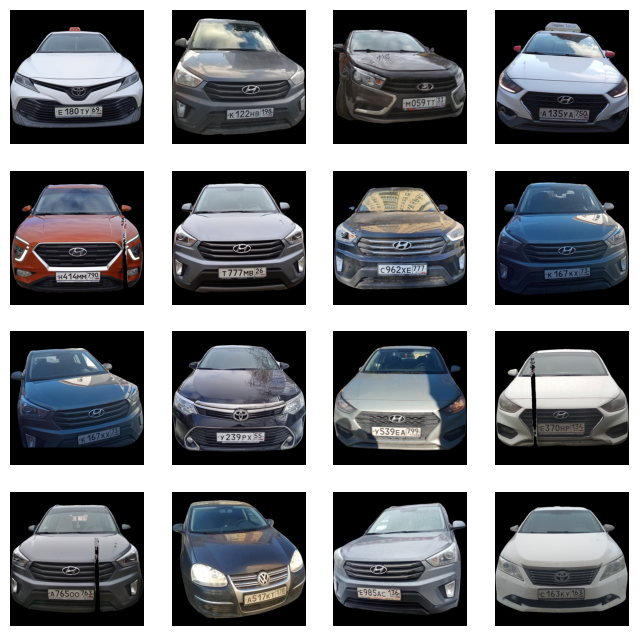

In [ ]:


fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, image in enumerate(dataset[0:16]["image"]):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(image)
    axs[row, col].set_axis_off()

plt.show()

# Предобработка данных

## Метод transform

Если элементы выборки имеют различную размерность, то мы можем привести всех к одному стандарту:
* `Resize` приводит изображения в соответствие с квадратным разрешением `config.image_size`
* `RandomHorizontalFlip` изменяет набор данных путем случайного зеркального отображения изображений.
* `Normalize` важно изменить масштаб значений пикселей в диапазоне `[-1, 1]`.

In [ ]:

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

## Изображения после трансформации



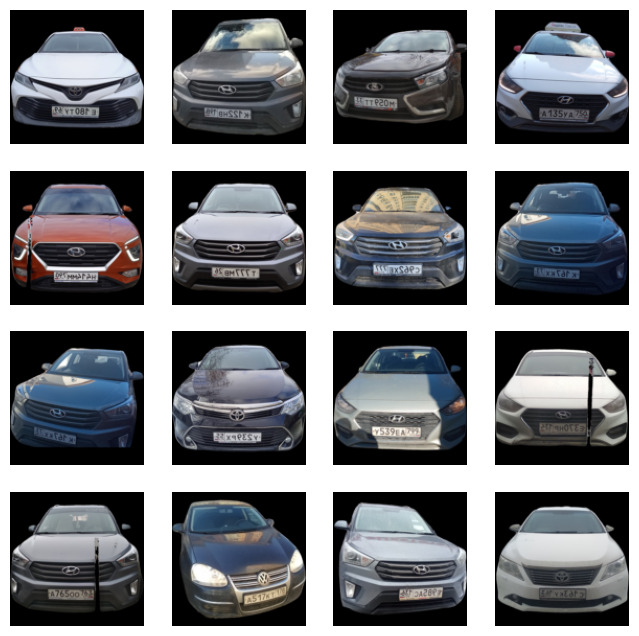

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, image in enumerate(dataset[0:16]["images"]):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[row, col].set_axis_off()
fig.show()


Сейчас все изображения точно одинаковых размеров и мы можем создать dataloader для последующего обучения.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Описание диффузионной модели

Модели диффузии представляют собой нейронные сети, которые обучаются предсказывать изображения, имеющие немного меньший уровень шума по сравнению с зашумленным входом. При выводе они могут использоваться для итеративного преобразования случайного шума в генерацию изображения:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Рисунок представлен из статьи (https://arxiv.org/abs/2006.11239). </em>
<p>
Интересная часть заключается в том, что добавление некоторого шума к изображению действительно очень просто, поэтому обучение может проходить в полу-супервизионном режиме следующим образом:

1. Берем изображение из обучающего набора.
2. Применяем к нему случайный шум $t$ раз (это даст $x_{t-1}$ и $x_{t}$ на изображении выше).
3. Подаем это зашумленное изображение модели вместе со значением $t$.
4. Вычисляем потерю на основе вывода модели и зашумленного изображения $x_{t-1}$.

Затем мы можем применить градиентный спуск и повторить этот процесс несколько раз.

Главная идея таких моделей при генерации - предсказание изображения с меньшим шумом.


Большинство моделей диффузии используют архитектуры, которые являются некоторым вариантом U-Net, и именно это мы будем использовать здесь.
https://arxiv.org/abs/1505.04597




![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

Итого:

- модель проходит входное изображение через несколько блоков слоев ResNet, которые уменьшают размер изображения вдвое.
- затем через то же количество блоков, которые восстанавливают исходный размер.

Основной особенностью этой модели является то, что она предсказывает изображения того же размера, что и входное изображение, что нам и нужно.

Diffusers предоставляют удобный класс UNet2DModel, который создает желаемую архитектуру в PyTorch.

Давайте создадим U-Net для нашего желаемого размера изображения.
Обратите внимание, что down_block_types соответствуют блокам уменьшения размера (зеленые на диаграмме выше), а up_block_types - блокам увеличения размера (красные на диаграмме):


# Создание модели UNet

In [ ]:
model = UNet2DModel(
    sample_size=config.image_size,  # Целевой размер изображения
    in_channels=3,  # Входной канал RGB
    out_channels=3,  # Выходной канал RGB
    layers_per_block=2,  # Количество ResNet слоев на каждый блок
    block_out_channels=(128, 128, 256, 256, 512, 512),  # Числа выходных каналов в каждом UNet block
    down_block_types=(
        "DownBlock2D",  # Обычный блок понижающей дискретизации ResNet
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet понижающей дискретизации с межпространственным вниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # Обычный блок повышающей дискретизации ResNet
        "AttnUpBlock2D",  # a ResNet повышающей дискретизации с межпространственным вниманием
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

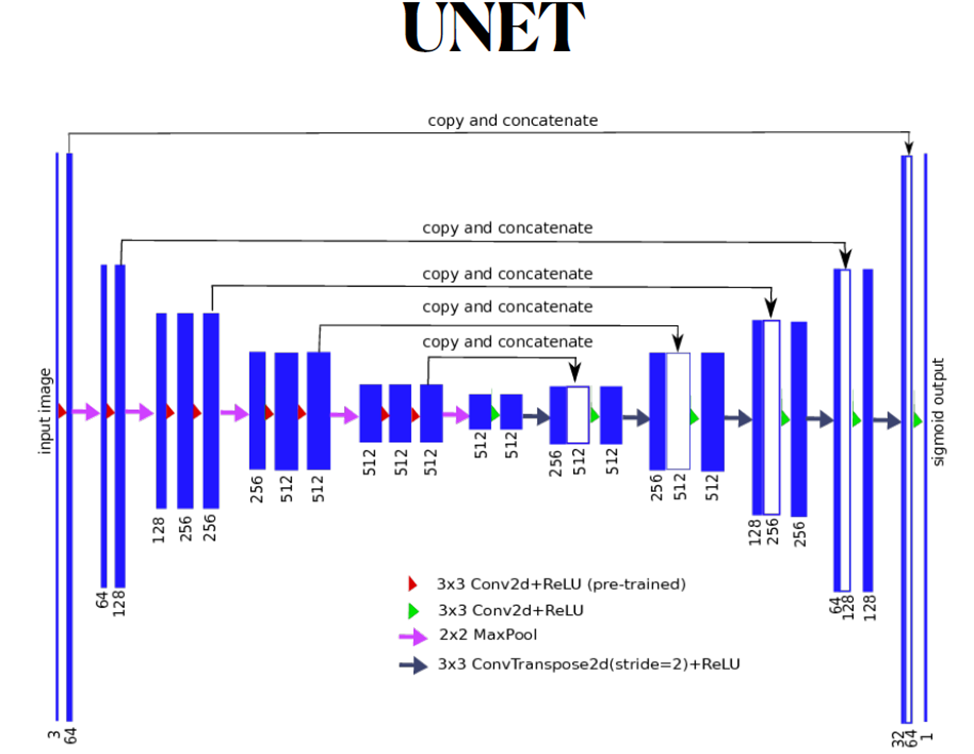

Возьмем пример одного элемента (изображения) и пропустим его через нашу нейросеть. Узнаем его размеры начальные размеры

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


Проверим размерность выходного примера (размеры тензоров должны совпадать)

In [ ]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


Теперь, когда у нас есть модель, нам просто нужен объект, который будет добавлять шум к изображению. Это делается с помощью планировщиков (schedulers) в библиотеке diffusers.


## Определим генератор шума

В зависимости от алгоритма диффузии, который используется, способ добавления шума к изображениям может немного отличаться. Именно поэтому в библиотеке Diffusers содержатся различные классы Schedulers, каждый из которых определяет алгоритм-специфичные шаги диффузии. Здесь мы будем использовать класс DDPMScheduler, который соответствует алгоритму обучения денойзинга и обучению, предложенному в [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # количество шагов диффузии, используемых для обучения модели.

Давайте посмотрим, как работает этот scheduler:

он принимает пакет изображений из обучающего набора данных (здесь мы повторно используем пакет из одного изображения `sample_image`, который мы использовали ранее), пакет случайного шума того же размера и `timesteps` для каждого изображения (которые соответствуют количеству раз, которое мы хотим применить шум к каждому изображению):

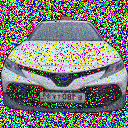

In [ ]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

В DDPM алгоритме, целью обучения модели является предсказание используемого нами шума в noise_scheduler.add_noise, поэтому потеря на этом этапе будет равна loss

In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Настройка обучения

### Определение оптимизатора

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [ ]:
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Метод оценки изображений

Для оценки нашей модели мы используем DDPMPipeline, который представляет собой простой способ выполнить полный вывод. Мы будем использовать этот конвейер для генерации пакета образцовых изображений и сохранения его в виде сетки на диск.

In [ ]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Генерация некоторых изображений из случайного шума (это процесс обратной диффузии)
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Создание сетки из изображений
    image_grid = make_grid(images, rows=2, cols=2)

    # Сохранение изображений
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Подготовка к обучению

С помощью этого мы можем объединить все вместе и написать нашу функцию обучения. Она просто оборачивает шаг обучения в цикл, используя Accelerate для удобного ведения журнала TensorBoard, накопления градиентов, обучения смешанной точности и обучения на нескольких GPU или TPU.

In [ ]:
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Инициализируем accelerate и tensorboard логгирование
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Подготовим параметры
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Непосредственно обучение модели
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Создание шума
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Добавление шума к изображению (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Предсказание остаточного шума
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # После каждой эпохи сохраняем данные о модели и примеры сгенерированных изображений
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                    # model.push_to_hub(commit_message=f"Model №{epoch+1}", blocking=True)
                    save_model(model, '/content/drive/MyDrive/Курсач/Models')
                else:
                    pipeline.save_pretrained(config.output_dir)

## Непосредственное обучение

Запустим обучение с помощью notebook_launcher, передав необходимые параметры

In [ ]:
torch.cuda.is_available() # Проверка на доступ к GPU

True

In [ ]:
def get_pipeline(model):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )
    unet = accelerator.unwrap_model(model.to('cuda'))

    pipeline = DDPMPipeline(
        unet=unet,
        scheduler=noise_scheduler,
    )

    return pipeline


def save_model(my_pipeline, dir):
    my_pipeline.save_pretrained(dir)  # Куда сохраняем


def load_model(dir):
    loaded_model = UNet2DModel.from_pretrained(dir, subfolder="unet")
    # args = (config, loaded_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

    # notebook_launcher(train_loop, args, num_processes=1)
    return loaded_model


def view_gen_images(dir='/content/*.png', limit=16):
    sample_images = sorted(glob.glob(dir))
    target_images = [img for img in sample_images if img.startswith('/content/00')]

    # Ограничиваем количество изображений
    target_images = target_images[:limit]

    # Создаем сетку изображений
    grid_size = (4, 4)  # Размер сетки
    fig, axs = plt.subplots(*grid_size, figsize=(6, 8))

    for i, image_path in enumerate(target_images):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image = Image.open(image_path)
        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.tight_layout()
    plt.show()


def generate_images(my_pipeline, num_images=1, dir="/content"):

    images = my_pipeline(
        batch_size=num_images,
        generator=torch.manual_seed(2),
    ).images

    # Обработка и сохранение изображений

    os.makedirs(dir, exist_ok=True)

    for i, image in enumerate(images):
        image.save(f"{dir}/{i:04d}.png")

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

https://huggingface.co/datasets/DanGlado/Duff_Hyundai

# Результаты

Посмотрим на получившееся изображения на последней эпохе

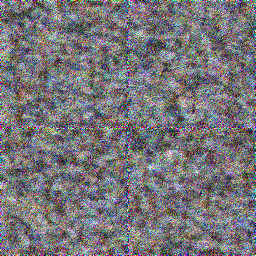

In [ ]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

Несмотря на отличный результат, стоит отметить, что здесь есть возможности для улучшения
Мы могли бы изменить некоторые гиперпараметры, увеличить разрешение изображений или даже поменять архитектуру нейросети, добавив слои понижающей и повышающей размерностей.

#TODO: Сохранение и загрузка модели

In [ ]:
# Генерация изображений
my_pipeline = get_pipeline(model)

generate_images(my_pipeline, 16)

view_gen_images()

TEST

In [ ]:
# save_model(model, '/content/unet')

In [ ]:
# loaded_model = load_model('/content')


In [ ]:
# loaded_pipeline = get_pipeline(loaded_model)
# generate_images(my_pipeline, 2)

# view_gen_images()